In [1]:
import Colors
using Statistics

In [2]:
include("../path.jl")
include("../ToolBox/ToolBox.jl")
using .ToolBox
using .Geometry

## Chose the burst

In [3]:
burst_n = 4;

In [4]:
# load meta and pod
master_meta = Load.slc_meta(master_meta_path);
master_precise_orbit = Load.precise_orbit(master_pod_path,master_meta["t_0"]);
slave_meta = Load.slc_meta(slave_meta_path);
slave_precise_orbit = Load.precise_orbit(slave_pod_path,slave_meta["t_0"]);

meta = (master_meta,slave_meta)
precise_orbit = (master_precise_orbit,slave_precise_orbit);

In [5]:
lines_per_burst = master_meta["lines_per_burst"];

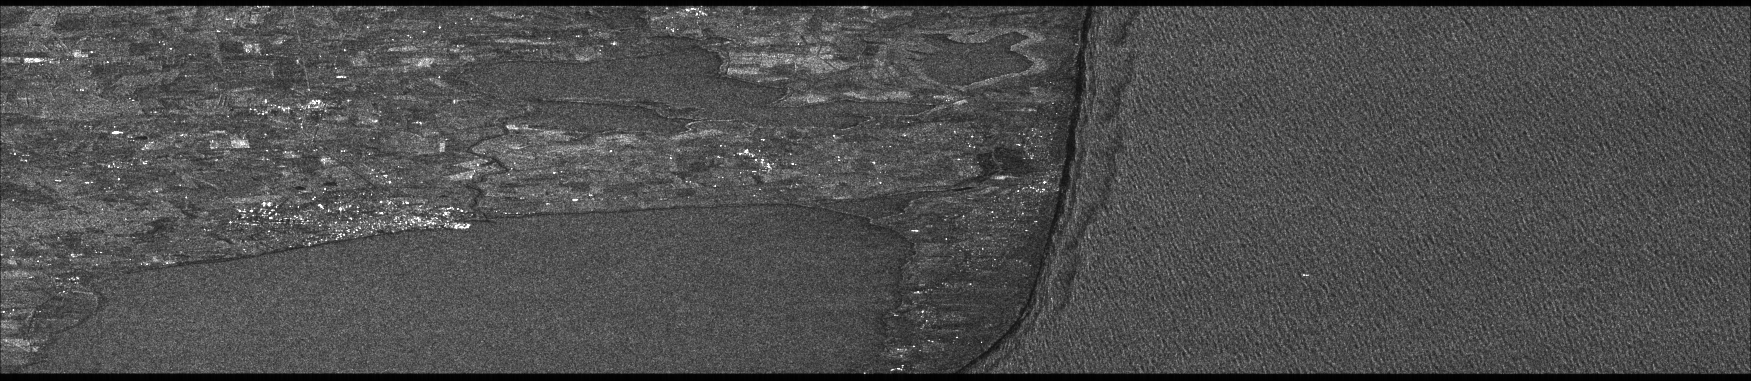

In [6]:
master_view = [(lines_per_burst*(burst_n-1)+4):(lines_per_burst*burst_n),3000:10000]
master_data = Load.slc_data(master_data_path,master_view)
SlcUtil.show_img(master_data,0.995)

In [7]:
# load DEM
footprint = SlcUtil.footprint(master_meta, master_view)
latlon_window = ((minimum(footprint[1]),maximum(footprint[1])),(minimum(footprint[2]),maximum(footprint[2])))
dem = Load.dem(dem_path, latlon_window; nan_fill= 0, padding=[90,90]);

## Handle ovelap

In [8]:
first_line_mosaic_master = master_meta["burst_meta"]["first_line_mosaic"][burst_n]
first_line_mosaic_slave = slave_meta["burst_meta"]["first_line_mosaic"][burst_n]
over_lap_master = lines_per_burst*(burst_n-1)+1 - (first_line_mosaic_master)
over_lap_slave = lines_per_burst*(burst_n-1)+1 - (first_line_mosaic_slave)

548

In [9]:
org_view = SlcUtil.mosaic_view(master_meta,master_view)

2-element Array{UnitRange{Int64},1}:
 4030:5550 
 3000:10000

In [10]:
lut = look_up_table(org_view,meta,precise_orbit,dem,stride=(2,8));

In [11]:
lut["master_line"] = lut["master_line"] .+ over_lap_master
lut["slave_line"] = lut["slave_line"] .+ over_lap_slave;

### resample

In [12]:
dim = (length(master_view[1]),length(master_view[2]))

(1521, 7001)

In [13]:
padd = 2

slave_view = round(Int,minimum(lut["slave_line"])-padd): round(Int,maximum(lut["slave_line"])+padd),
            round(Int,minimum(lut["slave_sample"])-padd): round(Int,maximum(lut["slave_sample"])+padd)
slave_data = Load.slc_data(slave_data_path, slave_view);

In [14]:
v_mid = Geometry.mid_burst_speed(precise_orbit[2], meta[2]);

In [109]:
line, sample = Misc.flatten(slave_view...)
line = line.-(1-burst_n).*lines_per_burst; # includer i deramp
phi = SlcUtil.phase_ramp(line, sample, burst_n, meta[2], v_mid[burst_n]);

In [110]:
phi = SlcUtil.phase_ramp(line, sample, burst_n, meta[2], v_mid[burst_n]) 
de_ramp = slave_data .* reshape(exp.(-phi .* im),size(slave_data));

In [111]:
slave_resample = Misc.resample(slave_view,de_ramp,lut["slave_line"],lut["slave_sample"])
slave_resample = reshape(slave_resample, dim);

In [112]:
# includer i reramp
dline = mean(lut["slave_line"].-lut["master_line"])
dsample = mean(lut["slave_sample"].-lut["master_sample"])
line = lut["master_line"].+dline .-(1-burst_n).*lines_per_burst
sample = lut["master_sample"].+dsample


phi = SlcUtil.phase_ramp(line, sample, burst_n, meta[2], v_mid[burst_n]) 


reramp = slave_resample .* reshape(exp.(phi .* im),dim);


In [113]:
function plot_phase(img)
    phase = (angle.(img) .+pi)./(2*pi)
    return Colors.RGB{Float32}.(1 .-phase.^2,4 .*(phase .-  phase.^2),phase.^2)
end

plot_phase (generic function with 1 method)

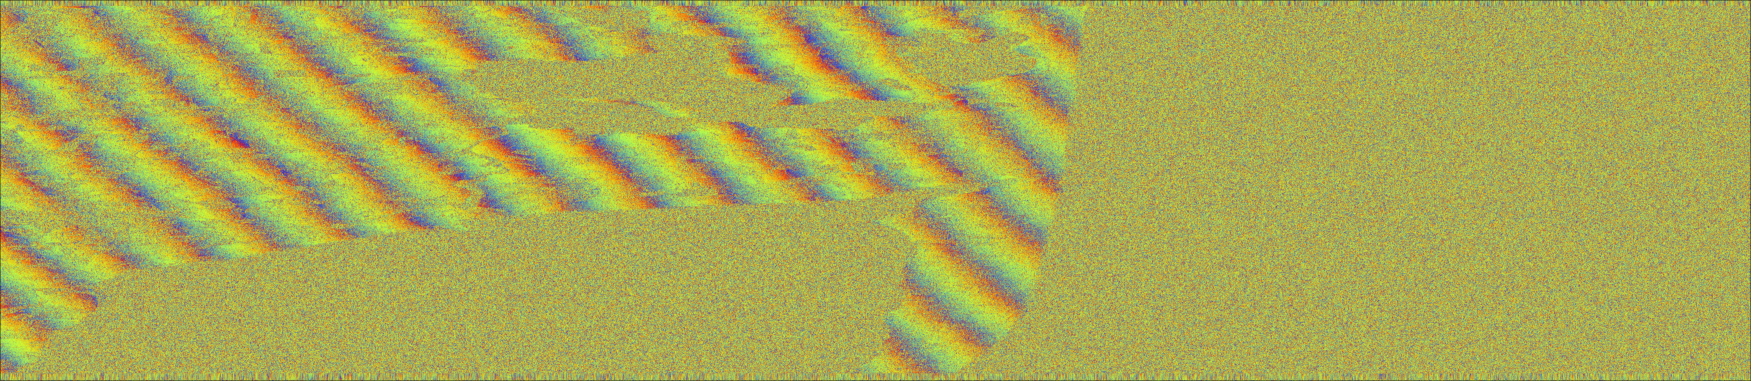

In [114]:
infero = master_data .* conj.(reramp)
plot_phase(infero)

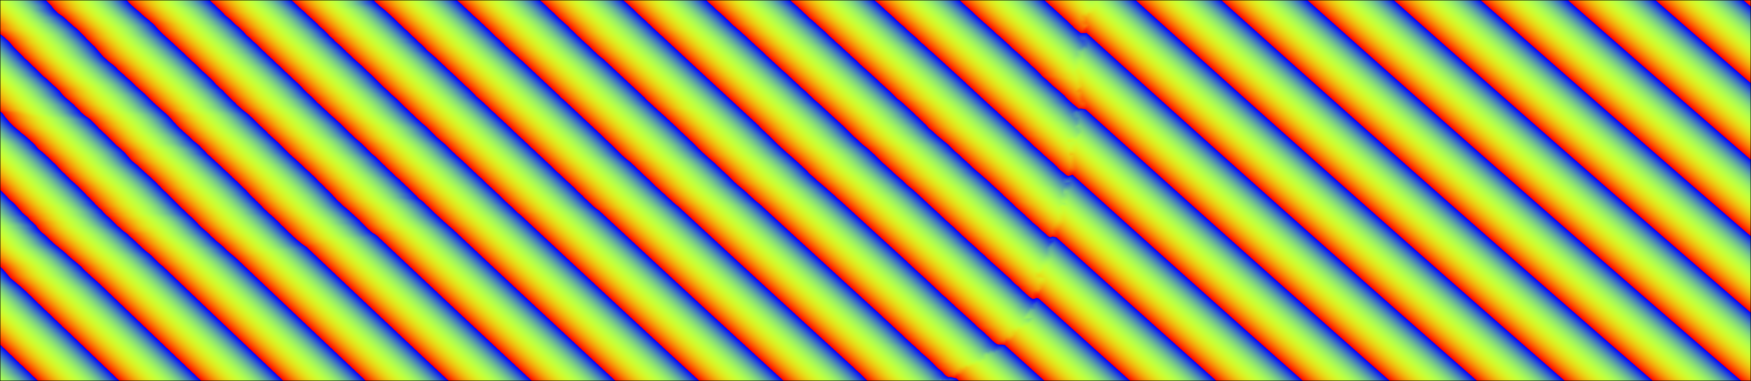

In [115]:
c = 299792458
range_pixel_spacing =  c/(2*meta[1]["range_sampling_rate"])
lambda =  c/meta[1]["radar_frequency"]
flat = exp.(4*pi.*(lut["master_sample"].-lut["slave_sample"]).*range_pixel_spacing./lambda.*im)
flat = reshape(flat,dim);
plot_phase(flat)

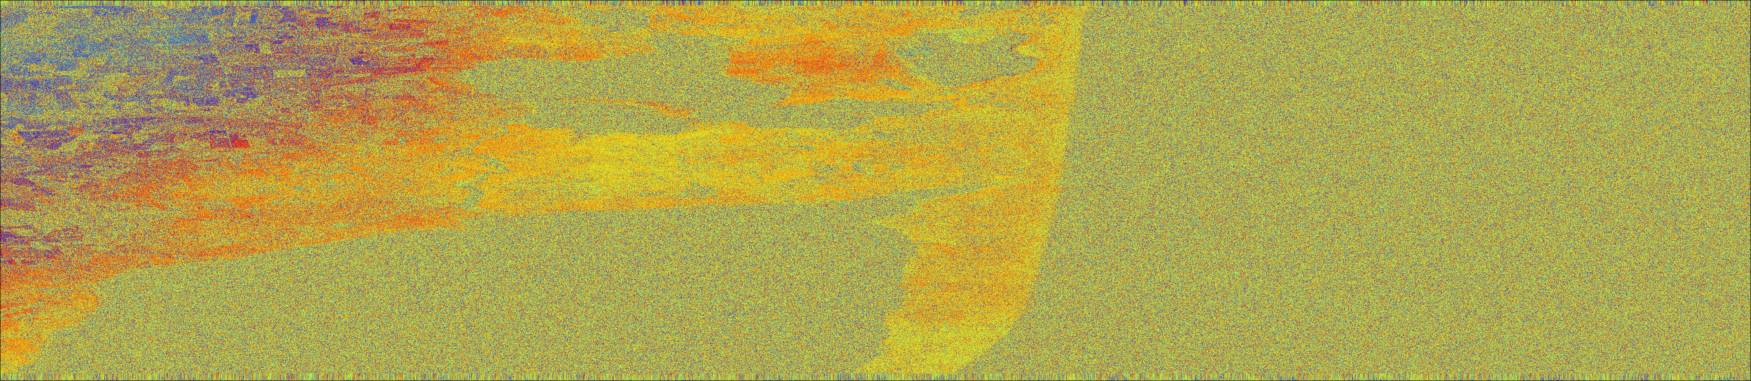

In [116]:
plot_phase(infero.*flat)

In [69]:
#import FileIO
#FileIO.save("infero_b4_fixed_deramp.jpg", plot_phase(infero.*flat))